In [1]:
import os, glob, sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns
from scipy import signal
import shutil
import warnings
warnings.filterwarnings('ignore')

#clog('critical') 
import re

import generic_tools_pl as gt   # like hexcolor(), ...

In [2]:
region="48"

'''all_models=['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
            'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
            'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
            'NorESM2-LM']'''


all_models=['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
            'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
            'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MRI-ESM2-0',
            'NorESM2-LM']

In [3]:
# Open the .nc file using xarray
ds = xr.open_dataset('/usr/home/habbar/Bureau/data_nc/Projet-long-2022-2023/CNRM-CM6-1_hist-aer_Reg.nc')
# Convert the dataset to a Pandas DataFrame
df = ds.to_dataframe().reset_index()
# Print the DataFrame
df

,time,region,height,abbrevs,names,tas_r1i1p1f2_ano,tas_r3i1p1f2_ano,tas_r4i1p1f2_ano,tas_r5i1p1f2_ano,tas_r6i1p1f2_ano,tas_r7i1p1f2_ano,tas_r8i1p1f2_ano,tas_r9i1p1f2_ano
0,1850-07-01 06:00:00,0,2.0,GIC,Greenland/Iceland,1.670194,-0.618236,0.277760,0.640676,-2.265909,-0.536204,-0.296294,-0.488982
1,1850-07-01 06:00:00,1,2.0,NWN,N.W.North-America,1.574372,-0.739538,-1.356860,-0.086705,-2.024924,-2.025759,-0.477895,-0.802556
2,1850-07-01 06:00:00,2,2.0,NEN,N.E.North-America,0.385013,-1.665699,-1.146537,-0.131862,-2.297973,-1.203468,-1.152259,-1.014513
3,1850-07-01 06:00:00,3,2.0,WNA,W.North-America,0.657727,0.841718,-0.147230,0.537758,-1.232942,-0.313951,0.161883,0.155490
4,1850-07-01 06:00:00,4,2.0,CNA,C.North-America,-0.430464,1.669536,0.439607,-0.280434,-0.976550,-1.108719,0.237038,0.809392
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9565,2014-07-01 06:00:00,53,2.0,ARS,Arabian-Sea,-0.639887,-0.677805,-0.623513,-0.564105,-0.670275,-0.580052,-0.347383,-0.435859
9566,2014-07-01 06:00:00,54,2.0,BOB,Bay-of-Bengal,-0.785619,-0.614185,-0.418357,-0.820651,-0.682892,-0.613287,-0.443133,-0.517562
9567,2014-07-01 06:00:00,55,2.0,EIO,Equatorial.Indic-Ocean,-0.662417,-0.586560,-0.435898,-0.652554,-0.594017,-0.647154,-0.252532,-0.434391
9568,2014-07-01 06:00:00,56,2.0,SIO,S.Indic-Ocean,-0.533473,-0.402577,-0.419070,-0.433284,-0.465500,-0.321196,-0.367522,-0.258857


In [4]:
# Chemin d'accès vers les fichiers de modèle climatique
chemin_dacces = "/usr/home/habbar/Bureau/data_nc/Projet-long-2022-2023/*.nc"

nouveau_dossier = "/usr/home/habbar/Bureau/data_nc/region{}".format(region)
if not os.path.exists(nouveau_dossier):
    os.mkdir(nouveau_dossier)

# Boucle pour parcourir tous les fichiers de modèle climatique
for fichier in glob.glob(chemin_dacces):
    # Charger le fichier de modèle climatique dans un objet Dataset
    ds = xr.open_dataset(fichier)

    # Extraire les données de la zone spécifiée
    zone_region = ds.sel(region=int(region))

    # Écrire les données de la zone dans un nouveau fichier dans le nouveau dossier créé
    nouveau_fichier = os.path.join(nouveau_dossier, os.path.basename(fichier)[:-3] + f"_region{region}.nc").replace("\\", "/")
    zone_region.to_netcdf(nouveau_fichier)

In [5]:
data_dir = '/usr/home/habbar/Bureau/data_nc/region{}'.format(region)
# Exemple de lecture du forcage GHG ...
#  Lecture des profils d’anomalies de température de l'air, forcage GHG, pour tous les modeles
all_forcings = ['GHG', 'AER', 'NAT', 'HIST']
all_forc_file_ext = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

results_dict = {}

for model_name in all_models:
    model_dict = {}
    for forcing, forc_in_fname in zip(all_forcings, all_forc_file_ext):
        forcings_filename = f'{model_name}_{forc_in_fname}_Reg_region{region}.nc'
        
        profilsT_ds = xr.open_dataset(os.path.join(data_dir, forcings_filename))
        
        # comment savoir quelles variables de données dans le Dataset ?
        # c'est aussi la liste de membres du même forcage pour le modele en question
        list_nc_var = list(profilsT_ds.keys())

        model_dict[forcing] = len(list_nc_var)
        
        #del(profilsT_ds)
    results_dict[model_name] = model_dict

df = pd.DataFrame(results_dict)

All_sim=df.values
models=df.columns
forcings=df.index

# Chemin de sortie pour les fichiers
out_dir = '/usr/home/habbar/Bureau/data_nc/Out-My-nb-1'

# Créer un répertoire pour la région si celui-ci n'existe pas encore
region_dir = os.path.join(out_dir, "region{}".format(region))
if not os.path.exists(region_dir):
    os.makedirs(region_dir)

# Enregistrer All_sim_z48v0 comme fichier .p dans le répertoire de la région
with open(os.path.join(region_dir, "All_sim_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(All_sim, f)

# Enregistrer models_z48v0 comme fichier .p dans le répertoire de la région
with open(os.path.join(region_dir, "models_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(models.tolist(), f)

# Enregistrer forcings_z48v0 comme fichier .p dans le répertoire de la région
with open(os.path.join(region_dir, "forcings_z{}v0.p".format(region)), "wb") as f:
    pickle.dump(forcings.tolist(), f)

In [6]:
# Chemin d'accès vers les fichiers NetCDF
chemin_dacces = "/usr/home/habbar/Bureau/data_nc/region{}/*.nc".format(region)

# Liste des types de forçage
types_forçage = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

# Liste des noms de modèles
#noms_modeles = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM']
noms_modeles = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']

# Boucle pour parcourir tous les types de forçage
for forçage in types_forçage:
    # Dictionnaire pour stocker les dataframes pour chaque modèle
    df_dict = {}

    # Boucle pour parcourir tous les fichiers NetCDF correspondant au type de forçage
    for fichier in glob.glob("/usr/home/habbar/Bureau/data_nc/region{}/*_{}_*.nc".format(region, forçage)):
        # Extraire le nom du modèle à partir du nom de fichier
        modele = [nom_modele for nom_modele in noms_modeles if nom_modele in fichier][0]

        # Vérifier si le modèle existe déjà dans le dictionnaire
        if modele not in df_dict:
            # Si le modèle n'existe pas, créer un nouveau dataframe
            df_dict[modele] = pd.DataFrame()

        # Ouvrir le fichier NetCDF et extraire les données
        ds = xr.open_dataset(fichier)
        df = ds.to_dataframe().reset_index()
        # print(df.iloc[:, :5].columns.values.tolist())
        df = df.loc[:,(list(ds.keys()))]
        df = df.transpose().reset_index().rename(columns={'index': 'Variable'})
        # Ajouter les données au dataframe correspondant
        df['modele'] = modele
        df_dict[modele] = pd.concat([df_dict[modele], df])

    # Vérifier si au moins un modèle a été traité pour le type de forçage
    if df_dict:
        # Vérifier si chaque dataframe pour le modèle contient des données
        df_dict_filtered = {k: v for k, v in df_dict.items() if not v.empty}
#       Trier les dataframes de chaque modèle en fonction de l'ordre des modèles
        df_dict_sorted = {modele: df_dict_filtered[modele] for modele in noms_modeles if modele in df_dict_filtered}
        # Concaténer les dataframes de tous les modèles pour le type de forçage
        df_concat = pd.concat(df_dict_sorted.values())
        # Add the 'modele' column as the first column
        df_concat.insert(0, 'modele', df_concat.pop('modele'))    
        # Écrire le dataframe dans un fichier CSV
        fichier_sortie = "/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region{}/{}_{}.csv".format(region, forçage, region)
        df_concat.to_csv(fichier_sortie, index=False)

        
        print(fichier_sortie)
        print(f"Données pour le type de forçage {forçage}: {df_concat.shape}")
    else:
        # Afficher un message d'avertissement si aucun modèle n'a été trouvé pour le type de forçage
        print(f"Aucun modèle trouvé pour le type de forçage {forçage}")

/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region48/hist-GHG_48.csv
Données pour le type de forçage hist-GHG: (100, 167)
/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region48/hist-aer_48.csv
Données pour le type de forçage hist-aer: (79, 167)
/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region48/hist-nat_48.csv
Données pour le type de forçage hist-nat: (110, 167)
/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region48/historical_48.csv
Données pour le type de forçage historical: (206, 167)


In [7]:
'''
source_path = 'C:/Users/cchoquet/Desktop/Out-My-nb-1/region{}'.format(region) 
target_path = 'C:/Users/cchoquet/Desktop/data_nc/Out-My-nb-1'

shutil.move(source_path, target_path)
'''

"\nsource_path = 'C:/Users/cchoquet/Desktop/Out-My-nb-1/region{}'.format(region) \ntarget_path = 'C:/Users/cchoquet/Desktop/data_nc/Out-My-nb-1'\n\nshutil.move(source_path, target_path)\n"

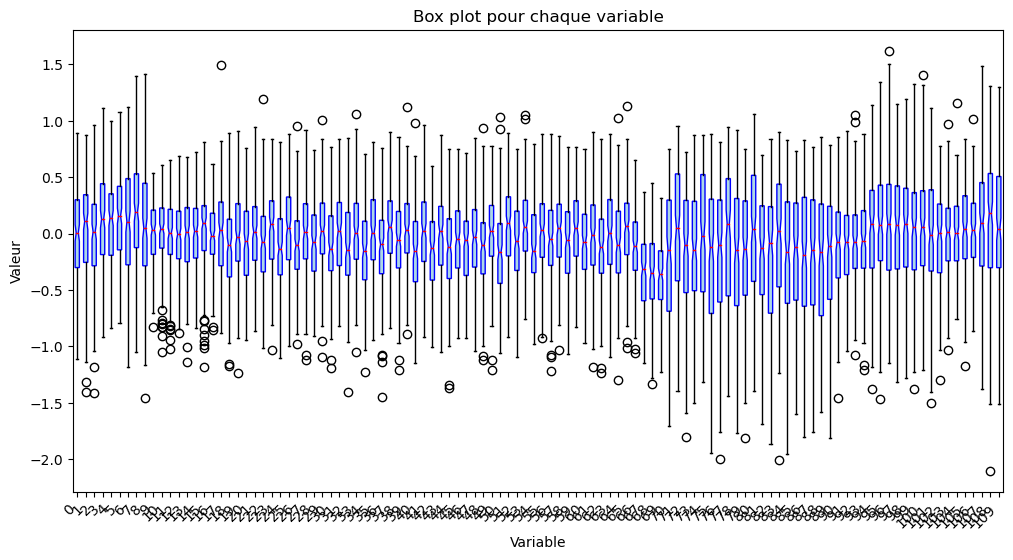

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le fichier CSV
df = pd.read_csv("/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region{}/hist-nat_{}.csv".format(region, region))

# Supprimer les deux premières colonnes
df = df.iloc[:, 2:]
df = df.T
# Créer un box plot pour chaque colonne
fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot(df.values, patch_artist=True, notch=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='red'))

# Personnaliser les labels et l'axe des ordonnées
ax.set_xticklabels(df.columns, rotation=45, ha='right')
ax.set_ylabel('Valeur')
ax.set_xlabel('Variable')

# Ajouter une légende pour le box plot
box_colors = ['lightblue']*len(df.columns)
box_colors[0] = 'blue'
handles = [plt.Rectangle((0,0),1,1, color=box_colors[i]) for i in range(len(df.columns))]
labels = df.columns
ax.set_title('Box plot pour chaque variable')
plt.show()

In [8]:
# Charger le fichier CSV
df = pd.read_csv("/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region{}/hist-GHG_{}.csv".format(region, region))

# Supprimer les deux premières colonnes
df = df.iloc[:, 2:]
df=  df.T
# Diviser les colonnes en sous-ensembles de 20 variables
n_cols = len(df.columns)
subsets = [df.iloc[:, i:i+7] for i in range(0, n_cols, 7)]

'''
# Créer une matrice de corrélation pour chaque sous-ensemble
for i, subset in enumerate(subsets):
    corr_matrix = subset.corr()

    # Masquer les valeurs de corrélation faibles
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True

    # Afficher la matrice de corrélation
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(f'Matrice de corrélation {i+1}')
    plt.show()
    # Afficher le diagramme de dispersion
    sns.pairplot(subset)
    plt.title(f'Diagramme de dispersion {i+1}')
    plt.show()
'''

"\n# Créer une matrice de corrélation pour chaque sous-ensemble\nfor i, subset in enumerate(subsets):\n    corr_matrix = subset.corr()\n\n    # Masquer les valeurs de corrélation faibles\n    mask = np.zeros_like(corr_matrix)\n    mask[np.triu_indices_from(mask)] = True\n\n    # Afficher la matrice de corrélation\n    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)\n    plt.title(f'Matrice de corrélation {i+1}')\n    plt.show()\n    # Afficher le diagramme de dispersion\n    sns.pairplot(subset)\n    plt.title(f'Diagramme de dispersion {i+1}')\n    plt.show()\n"

In [9]:
import pandas as pd

# chemin du dossier contenant les fichiers .nc
data_dir = '/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region{}'.format(region)


# parcours de tous les fichiers .nc dans le dossier
for file_name in os.listdir(data_dir):
    if file_name.endswith('.nc'):
        # ouverture du fichier netcdf avec xarray
        ds = xr.open_dataset(os.path.join(data_dir, file_name))

        # suppression des colonnes contenant des valeurs supérieures à 10
        ds = ds.where((ds <= 20)).drop_vars(ds.coords) 

        # remplacement des valeurs NaN par la moyenne des données
        ds = ds.fillna(ds.mean(dim=None))

        # enregistrement du fichier modifié
        ds.to_netcdf(os.path.join(data_dir, file_name))

In [10]:
# copier un dossier et le mettre dans un autre endroit
import shutil

source_path = '/usr/home/habbar/Bureau/data_nc/region{}'.format(region)
target_path = '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/' 

shutil.move(source_path, target_path)

'/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/region48'

In [11]:
data_dir = '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/region{}'.format(region)

# Exemple de lecture du forcage GHG ...
#  Lecture des profils d’anomalies de température de l'air, forcage GHG, pour tous les modeles
all_forcings = ['GHG', 'AER', 'NAT', 'HIST']
all_forc_file_ext = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

results_dict = {}

for model_name in all_models:
    model_dict = {}
    for forcing, forc_in_fname in zip(all_forcings, all_forc_file_ext):
        forcings_filename = f'{model_name}_{forc_in_fname}_Reg_region{region}.nc'
        
        profilsT_ds = xr.open_dataset(os.path.join(data_dir, forcings_filename).replace('\\','/'))
        
        # comment savoir quelles variables de données dans le Dataset ?
        # c'est aussi la liste de membres du même forcage pour le modele en question
        list_nc_var = list(profilsT_ds.keys())

        model_dict[forcing] = len(list_nc_var)
        
        #del(profilsT_ds)
    results_dict[model_name] = model_dict

df = pd.DataFrame(results_dict)

All_sim=df.values
models=df.columns
forcings=df.index

In [12]:
import shutil

source_path1 = '/usr/home/habbar/Bureau/data_nc/Out-My-nb-1/region{}'.format(region)
target_path1 = '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/'

# en lui changeant le nom
shutil.move(source_path1, target_path1)

'/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/region48'

In [13]:
# Chemin de sortie pour les fichiers
out_dir = '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/region{}'.format(region)

# Enregistrer All_sim_z48v0 comme fichier .p
with open(os.path.join(out_dir, "All_sim_z{}v0.p".format(region)).replace('\\','/'), "wb") as f:
    pickle.dump(All_sim, f)

# Enregistrer models_z48v0 comme fichier .p
with open(os.path.join(out_dir, "models_z{}v0.p".format(region)).replace('\\','/'), "wb") as f:
    pickle.dump(models.tolist(), f)

# Enregistrer forcings_z48v0 comme fichier .p
with open(os.path.join(out_dir, "forcings_z{}v0.p".format(region)).replace('\\','/'), "wb") as f:
    pickle.dump(forcings.tolist(), f)

In [14]:
# Chemin d'accès vers les fichiers NetCDF
chemin_dacces = "/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/region{}/*.nc".format(region)

# Liste des types de forçage
types_forçage = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

# Liste des noms de modèles
#noms_modeles = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM']
noms_modeles = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']

# Boucle pour parcourir tous les types de forçage
for forçage in types_forçage:
    # Dictionnaire pour stocker les dataframes pour chaque modèle
    df_dict = {}

    # Boucle pour parcourir tous les fichiers NetCDF correspondant au type de forçage
    for fichier in glob.glob("/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/region{}/*_{}_*_*.nc".format(region, forçage)):
        # Extraire le nom du modèle à partir du nom de fichier
        modele = [nom_modele for nom_modele in noms_modeles if nom_modele in fichier][0]

        # Vérifier si le modèle existe déjà dans le dictionnaire
        if modele not in df_dict:
            # Si le modèle n'existe pas, créer un nouveau dataframe
            df_dict[modele] = pd.DataFrame()

        # Ouvrir le fichier NetCDF et extraire les données
        ds = xr.open_dataset(fichier)
        df = ds.to_dataframe().reset_index()
        # print(df.iloc[:, :5].columns.values.tolist())
        df = df.loc[:,(list(ds.keys()))]
        df = df.transpose().reset_index().rename(columns={'index': 'Variable'})
        # Ajouter les données au dataframe correspondant
        df['modele'] = modele
        df_dict[modele] = pd.concat([df_dict[modele], df])

    # Vérifier si au moins un modèle a été traité pour le type de forçage
    if df_dict:
        # Vérifier si chaque dataframe pour le modèle contient des données
        df_dict_filtered = {k: v for k, v in df_dict.items() if not v.empty}
#       Trier les dataframes de chaque modèle en fonction de l'ordre des modèles
        df_dict_sorted = {modele: df_dict_filtered[modele] for modele in noms_modeles if modele in df_dict_filtered}
        # Concaténer les dataframes de tous les modèles pour le type de forçage
        df_concat = pd.concat(df_dict_sorted.values())
        # Add the 'modele' column as the first column
        df_concat.insert(0, 'modele', df_concat.pop('modele'))    
        # Écrire le dataframe dans un fichier CSV
        fichier_sortie = f"{forçage}_{region}.csv"
        df_concat.to_csv(fichier_sortie, index=False)

        print(f"Données pour le type de forçage {forçage}: {df_concat.shape}")
    else:
        # Afficher un message d'avertissement si aucun modèle n'a été trouvé pour le type de forçage
        print(f"Aucun modèle trouvé pour le type de forçage {forçage}")

Données pour le type de forçage hist-GHG: (100, 167)
Données pour le type de forçage hist-aer: (79, 167)
Données pour le type de forçage hist-nat: (110, 167)
Données pour le type de forçage historical: (206, 167)


In [15]:
# lire les fichiers csv en tant que dataframe
hist_GHG = pd.read_csv('hist-GHG_{}.csv'.format(region))
hist_aer = pd.read_csv('hist-aer_{}.csv'.format(region))
hist_nat = pd.read_csv('hist-nat_{}.csv'.format(region))
historical = pd.read_csv('historical_{}.csv'.format(region))

# supprimer les deux premières colonnes de chaque dataframe
hist_GHG = hist_GHG.iloc[:, 2:]
hist_aer = hist_aer.iloc[:, 2:]
hist_nat = hist_nat.iloc[:, 2:]
historical = historical.iloc[:, 2:]

# convertir chaque dataframe en tableau numpy (array)
hist_GHG = np.array(hist_GHG)
hist_aer = np.array(hist_aer)
hist_nat = np.array(hist_nat)
historical = np.array(historical)

#Lissage 
filt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
b_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)

'''hist_GHG = signal.filtfilt(b_lp_filter, a_lp_filter, hist_GHG)
hist_aer = signal.filtfilt(b_lp_filter, a_lp_filter, hist_aer)
hist_nat = signal.filtfilt(b_lp_filter, a_lp_filter, hist_nat)
historical = signal.filtfilt(b_lp_filter, a_lp_filter, historical)'''


# plt.plot(hist_GHG[:,:].T)
# Afficher le nombre de lignes et de colonnes du dataframe

# Définir le chemin où sauvegarder les fichiers .p
output_path = "/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/region{}".format(region)

# Sauvegarder chaque tableau numpy en tant que fichier .p
with open(os.path.join(output_path, 'T_ghg_z{}vnf.p'.format(region)), 'wb') as f:
    pickle.dump(hist_GHG, f)
with open(os.path.join(output_path, 'T_aer_z{}vnf.p'.format(region)), 'wb') as f:
    pickle.dump(hist_aer, f)
with open(os.path.join(output_path, 'T_nat_z{}vnf.p'.format(region)), 'wb') as f:
    pickle.dump(hist_nat, f)
with open(os.path.join(output_path, 'T_hist_z{}vnf.p'.format(region)), 'wb') as f:
    pickle.dump(historical, f)

In [17]:
# Chemin du dossier contenant les fichiers
chemin_dossier = "/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/region{}".format(region)

# Parcours du dossier
for fichier in os.listdir(chemin_dossier):
    
    # Vérification que le fichier est de type CSV
    if fichier.endswith('.csv'):
        
        # Chargement du fichier CSV dans un dataframe Pandas
        chemin_fichier = os.path.join(chemin_dossier, fichier)
        df_to_test = pd.read_csv(chemin_fichier)
        
        # Vérification des NaN dans le dataframe
        if df_to_test.isna().sum().sum() > 0:
            print(f'Le fichier {fichier} contient des valeurs manquantes.')
        else:
            print(f'Le fichier {fichier} ne contient pas de valeurs manquantes.')

Le fichier hist-GHG_48.csv ne contient pas de valeurs manquantes.
Le fichier hist-aer_48.csv ne contient pas de valeurs manquantes.
Le fichier hist-nat_48.csv ne contient pas de valeurs manquantes.
Le fichier historical_48.csv ne contient pas de valeurs manquantes.


In [18]:
'''noms_modeles = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                'NorESM2-LM']'''

noms_forcages = ['aer', 'GHG', 'nat']

for modele in noms_modeles:
    for forcage in noms_forcages:
        test = pd.read_csv("/usr/home/habbar/Bureau/data_nc/hist-{}_{}.csv".format(forcage,region))
        df_test = test[test.modele.str.contains(modele)]
        print(f"Modèle {modele} pour le type de forçage {forcage}: {df.shape}")
        print("La valeur maximale est: ", np.max(df_test.drop(columns=["modele","Variable"]).max()))
        df0 = df_test.drop(columns=["modele","Variable"]).values
        aberrant = (df0 > 100).any(axis=1)
        # Supprimer les lignes contenant des valeurs aberrantes
        df_clean_test = df0[~aberrant]
        # Afficher le nombre de lignes supprimées
        print("Nombre de lignes supprimées : ", len(df0) - len(df_clean_test))
        #print(df.iloc[~aberrant].describe())
        print("La valeur maximale est: ", np.max(df_test.iloc[~aberrant].drop(columns=["modele","Variable"]).max()))
        print("---------------------------------------------------------------------------------", "\n")

Modèle ACCESS-ESM1-5 pour le type de forçage aer: (3, 167)
La valeur maximale est:  0.7865375899110841
Nombre de lignes supprimées :  0
La valeur maximale est:  0.7865375899110841
--------------------------------------------------------------------------------- 

Modèle ACCESS-ESM1-5 pour le type de forçage GHG: (3, 167)
La valeur maximale est:  2.0749875334236787
Nombre de lignes supprimées :  0
La valeur maximale est:  2.0749875334236787
--------------------------------------------------------------------------------- 

Modèle ACCESS-ESM1-5 pour le type de forçage nat: (3, 167)
La valeur maximale est:  0.9614722013031008
Nombre de lignes supprimées :  0
La valeur maximale est:  0.9614722013031008
--------------------------------------------------------------------------------- 

Modèle BCC-CSM2-MR pour le type de forçage aer: (3, 167)
La valeur maximale est:  1.0738065948381377
Nombre de lignes supprimées :  0
La valeur maximale est:  1.0738065948381377
------------------------------

In [19]:
test1 = pd.read_csv("/usr/home/habbar/Bureau/data_nc/hist-nat_{}.csv".format(region))

df = test1[test1.modele.str.contains("CNRM-CM6-1")]
df

,modele,Variable,0,1,2,3,4,5,6,7,...,155,156,157,158,159,160,161,162,163,164
9,CNRM-CM6-1,tas_r1i1p1f2_ano,-0.184640,-0.254921,-0.044972,-0.203988,0.121659,0.033853,0.348175,0.034942,...,0.130778,-0.459116,-0.167391,0.407919,0.118489,-0.309273,0.170301,-0.076475,0.031953,0.169684
10,CNRM-CM6-1,tas_r3i1p1f2_ano,0.018083,-0.828878,-0.110306,-0.114184,0.138720,0.346015,-0.080052,0.207402,...,-1.052324,-0.179497,0.032311,-0.214036,0.257263,-0.423959,-0.207167,0.359059,0.366353,0.509428
11,CNRM-CM6-1,tas_r4i1p1f2_ano,0.004675,-0.081813,0.064609,-0.112787,-0.079748,0.058599,0.376951,-0.254083,...,0.030343,-0.317318,-0.248838,-0.200776,0.368658,0.323793,0.183240,-0.684444,-0.643122,0.268349
12,CNRM-CM6-1,tas_r5i1p1f2_ano,-0.122576,0.314107,-0.020854,-0.584268,0.428048,0.543719,-0.075909,-0.327757,...,0.064949,0.198657,0.338651,0.361816,0.047399,0.217447,0.060269,0.071092,0.111265,-0.016772
13,CNRM-CM6-1,tas_r6i1p1f2_ano,-0.549443,-0.271691,0.317359,-0.796511,-0.163262,-0.319697,-0.222146,0.380431,...,0.345734,-0.000862,0.098412,0.126940,-0.064059,-0.091612,-0.143060,0.516215,0.212451,-0.418230
14,CNRM-CM6-1,tas_r7i1p1f2_ano,0.098528,0.368495,0.034109,-0.375852,0.104457,0.446081,-0.310755,-0.561613,...,0.225180,-0.493898,-0.216903,0.135551,0.043867,0.137901,-0.136601,-0.121272,-0.064174,-0.025643
15,CNRM-CM6-1,tas_r8i1p1f2_ano,-0.161521,0.173570,0.286553,-0.393495,-1.012961,0.132666,0.472181,0.250209,...,-0.437361,-0.020346,0.321570,0.134880,-0.027445,-0.433677,0.447366,0.641347,0.343109,0.074802
16,CNRM-CM6-1,tas_r9i1p1f2_ano,-0.264610,0.083611,0.560481,-0.210793,-0.313910,0.569521,-0.130324,0.077849,...,-0.151292,-0.275447,0.255176,-0.580079,0.020263,-0.094442,-0.231675,0.352268,0.088781,-0.463951


In [20]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.145188,-0.062190,0.135873,-0.348985,-0.097125,0.226345,0.047265,-0.024078,-0.070266,-0.023022,...,-0.105499,-0.193478,0.051623,0.021527,0.095554,-0.084228,0.017834,0.132224,0.055827,0.012209
std,0.203024,0.391547,0.229671,0.241833,0.432659,0.305481,0.303191,0.325222,0.122405,0.407463,...,0.451189,0.240212,0.241898,0.331425,0.147612,0.291588,0.238902,0.428457,0.318736,0.328596
min,-0.549443,-0.828878,-0.110306,-0.796511,-1.012961,-0.319697,-0.310755,-0.561613,-0.231987,-0.633138,...,-1.052324,-0.493898,-0.248838,-0.580079,-0.064059,-0.433677,-0.231675,-0.684444,-0.643122,-0.463951
25%,-0.204632,-0.259114,-0.026883,-0.441188,-0.200924,0.052412,-0.153280,-0.272502,-0.185300,-0.233184,...,-0.222810,-0.352767,-0.179769,-0.204091,0.008336,-0.337945,-0.159086,-0.087674,0.007921,-0.123790
50%,-0.142049,0.000899,0.049359,-0.293322,0.012355,0.239340,-0.077981,0.056395,-0.036597,0.036551,...,0.047646,-0.227472,0.065361,0.130910,0.045633,-0.093027,-0.038166,0.211680,0.100023,0.029015
75%,0.008027,0.208704,0.294255,-0.181537,0.125924,0.470491,0.355369,0.218104,0.027210,0.224604,...,0.154379,-0.015475,0.271774,0.192117,0.153182,0.157788,0.173536,0.398348,0.245116,0.194350
max,0.098528,0.368495,0.560481,-0.112787,0.428048,0.569521,0.472181,0.380431,0.069090,0.468385,...,0.345734,0.198657,0.338651,0.407919,0.368658,0.323793,0.447366,0.641347,0.366353,0.509428


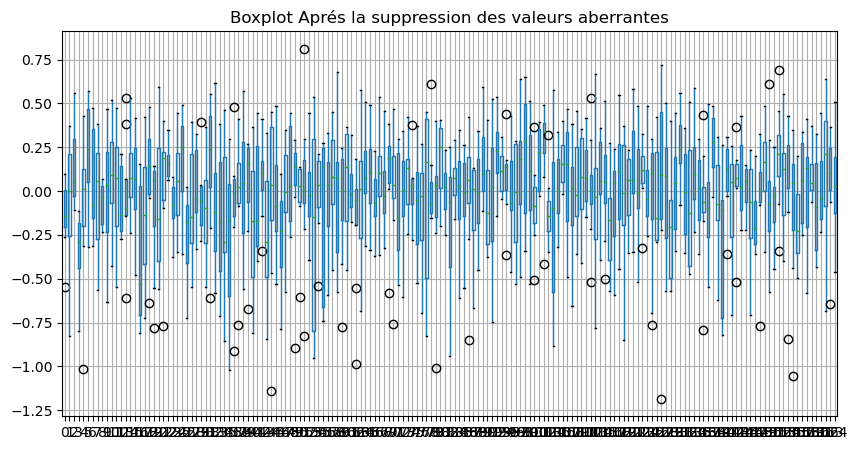

In [21]:
# Visualiser le boxplot avant la suppression des valeurs aberrantes
plt.figure(figsize=(10, 5))
plt.title("Boxplot Aprés la suppression des valeurs aberrantes")
df.boxplot()
plt.show()

Nombre de lignes supprimées :  0


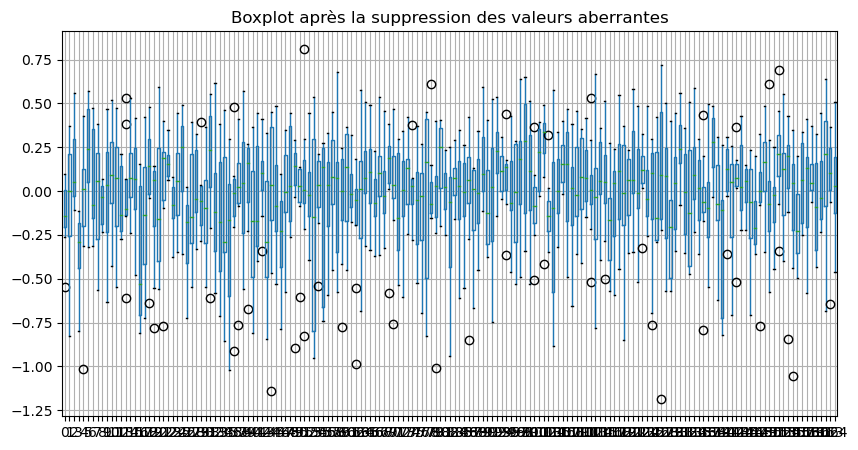

In [22]:
df = df.drop(columns=["modele","Variable"]).values
aberrant = (df > 100).any(axis=1)

# Supprimer les lignes contenant des valeurs aberrantes
df_clean = df[~aberrant]
# Afficher le nombre de lignes supprimées
print("Nombre de lignes supprimées : ", len(df) - len(df_clean))

# Convertir le tableau numpy en DataFrame pandas
df_clean = pd.DataFrame(df_clean)

# Visualiser le boxplot après la suppression des valeurs aberrantes
plt.figure(figsize=(10, 5))
plt.title("Boxplot après la suppression des valeurs aberrantes")
# afficher le boxplot en séparant chaque deux années
df_clean.boxplot()
plt.show()

In [23]:
df_clean.describe()

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.145188,-0.062190,0.135873,-0.348985,-0.097125,0.226345,0.047265,-0.024078,-0.070266,-0.023022,...,-0.105499,-0.193478,0.051623,0.021527,0.095554,-0.084228,0.017834,0.132224,0.055827,0.012209
std,0.203024,0.391547,0.229671,0.241833,0.432659,0.305481,0.303191,0.325222,0.122405,0.407463,...,0.451189,0.240212,0.241898,0.331425,0.147612,0.291588,0.238902,0.428457,0.318736,0.328596
min,-0.549443,-0.828878,-0.110306,-0.796511,-1.012961,-0.319697,-0.310755,-0.561613,-0.231987,-0.633138,...,-1.052324,-0.493898,-0.248838,-0.580079,-0.064059,-0.433677,-0.231675,-0.684444,-0.643122,-0.463951
25%,-0.204632,-0.259114,-0.026883,-0.441188,-0.200924,0.052412,-0.153280,-0.272502,-0.185300,-0.233184,...,-0.222810,-0.352767,-0.179769,-0.204091,0.008336,-0.337945,-0.159086,-0.087674,0.007921,-0.123790
50%,-0.142049,0.000899,0.049359,-0.293322,0.012355,0.239340,-0.077981,0.056395,-0.036597,0.036551,...,0.047646,-0.227472,0.065361,0.130910,0.045633,-0.093027,-0.038166,0.211680,0.100023,0.029015
75%,0.008027,0.208704,0.294255,-0.181537,0.125924,0.470491,0.355369,0.218104,0.027210,0.224604,...,0.154379,-0.015475,0.271774,0.192117,0.153182,0.157788,0.173536,0.398348,0.245116,0.194350
max,0.098528,0.368495,0.560481,-0.112787,0.428048,0.569521,0.472181,0.380431,0.069090,0.468385,...,0.345734,0.198657,0.338651,0.407919,0.368658,0.323793,0.447366,0.641347,0.366353,0.509428


In [24]:
# Ecraser cette modification dans le fichier de base (fichier CSV)
df_clean.to_csv("/usr/home/habbar/Bureau/data_nc/hist-nat_{}.csv".format(region), index=False)

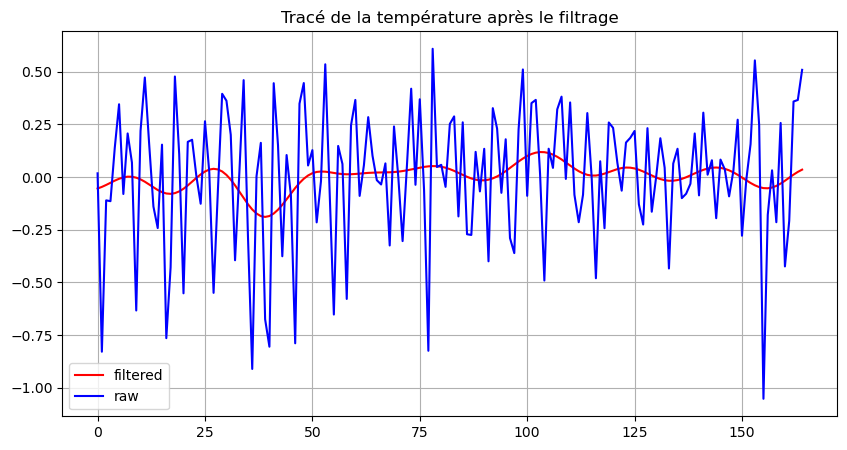

In [25]:
filt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
b_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)
tmp_filtered_arr = signal.filtfilt(b_lp_filter, a_lp_filter, df_clean, method = 'gust')
plt.figure(figsize=(10, 5))
plt.plot(tmp_filtered_arr[1,:].T, label="filtered", color='red')
plt.title("Tracé de la température après le filtrage")
plt.plot(df_clean.iloc[1,:].T, label="raw", color='blue')
#plt.plot(df_clean.T, label="raw", color='blue')
plt.legend(loc='best')
plt.grid()
plt.show()

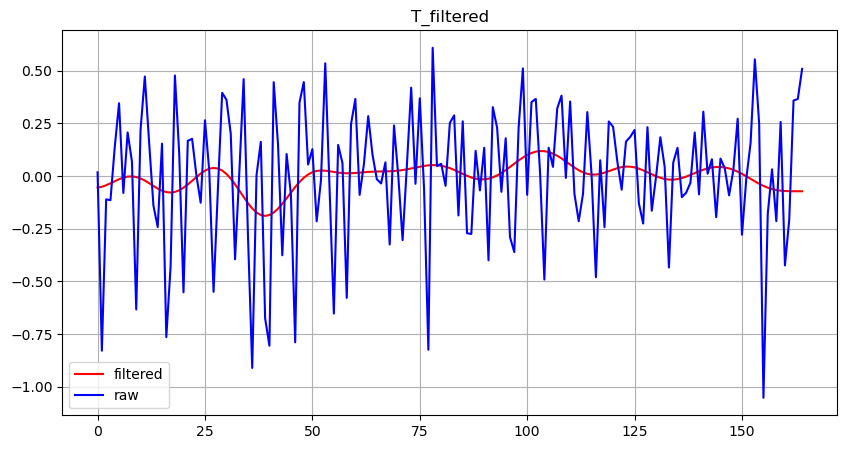

In [26]:
filt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
b_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)
tmp_filtered_arr = signal.filtfilt(b_lp_filter, a_lp_filter, df_clean, padtype=None)
plt.figure(figsize=(10, 5))
plt.plot(tmp_filtered_arr[1,:].T, label="filtered", color='red')
plt.title("T_filtered")
plt.plot(df_clean.loc[1,:], label="raw", color='blue')
plt.legend()
plt.grid()
plt.show()

In [27]:
# lire les fichiers csv en tant que dataframe
# hist_GHG = pd.read_csv('hist-GHG_{}.csv'.format(region))
# hist_aer = pd.read_csv('hist-aer_{}.csv'.format(region))
# hist_nat = pd.read_csv('hist-nat_{}.csv'.format(region))
historical = pd.read_csv('historical_{}.csv'.format(region))
historical = historical[historical["modele"] == "IPSL-CM6A-LR"]
historical = historical.reset_index(drop=True)
# supprimer les deux premières colonnes de chaque dataframe
# hist_GHG = hist_GHG.iloc[:, 2:]
# hist_aer = hist_aer.iloc[:, 2:]
# hist_nat = hist_nat.iloc[:, 2:]
historical = historical.iloc[:, 2:]


# convertir chaque dataframe en tableau numpy (array)
# hist_GHG = np.array(hist_GHG)
# hist_aer = np.array(hist_aer)
# hist_nat = np.array(hist_nat)
historical = np.array(historical)

#Lissage 
filt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
b_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)

# hist_GHG = signal.filtfilt(b_lp_filter, a_lp_filter, hist_GHG)
# hist_aer = signal.filtfilt(b_lp_filter, a_lp_filter, hist_aer)
# hist_nat = signal.filtfilt(b_lp_filter, a_lp_filter, hist_nat)
historical = signal.filtfilt(b_lp_filter, a_lp_filter, historical)


# plt.plot(hist_GHG[:,:].T)
# Afficher le nombre de lignes et de colonnes du dataframe

# Définir le chemin où sauvegarder les fichiers .p
output_path = "/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/"

# Sauvegarder chaque tableau numpy en tant que fichier .p
# with open(os.path.join(output_path, 'T_ghg_z{}v0.p'.format(region)), 'wb') as f:
#     pickle.dump(hist_GHG, f)
# with open(os.path.join(output_path, 'T_aer_z{}v0.p'.format(region)), 'wb') as f:
#     pickle.dump(hist_aer, f)
# with open(os.path.join(output_path, 'T_nat_z{}v0.p'.format(region)), 'wb') as f:
#     pickle.dump(hist_nat, f)
with open(os.path.join(output_path, 'T_hist_z{}v0.p'.format(region)), 'wb') as f:
    pickle.dump(historical, f)

In [28]:
# Open the .nc file using xarray
ds = xr.open_dataset('/usr/home/habbar/Bureau/data_nc/HadCRUT-Regions/data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.region.nc')
# Convert the dataset to a Pandas DataFrame
df_hadcrut = ds.to_dataframe().reset_index()
df_hadcrut
# Print the DataFrame
# df.to_csv("hadCrut.csv",index=False) 

,time,region,realization,abbrevs,names,tas_mean
0,1850,0,100,GIC,Greenland/Iceland,-0.340999
1,1850,1,100,NWN,N.W.North-America,-0.470905
2,1850,2,100,NEN,N.E.North-America,-0.439982
3,1850,3,100,WNA,W.North-America,0.144394
4,1850,4,100,CNA,C.North-America,0.069595
...,...,...,...,...,...,...
10087,2023,53,100,ARS,Arabian-Sea,0.448849
10088,2023,54,100,BOB,Bay-of-Bengal,0.330094
10089,2023,55,100,EIO,Equatorial.Indic-Ocean,0.266170
10090,2023,56,100,SIO,S.Indic-Ocean,0.294436


In [29]:
# Chemin d'accès vers les fichiers de modèle climatique
chemin_dacces = "/usr/home/habbar/Bureau/data_nc/HadCRUT-Regions/data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.region.nc"
nouveau_dossier = "/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/region{}/HadCRUT".format(region)
if not os.path.exists(nouveau_dossier):
    os.mkdir(nouveau_dossier)

# Boucle pour parcourir tous les fichiers de modèle climatique
for fichier in glob.glob(chemin_dacces):
    # Charger le fichier de modèle climatique dans un objet Dataset
    ds = xr.open_dataset(fichier)

    # Extraire les données de la zone spécifiée
    zone_region = ds.sel(region=int(region))

# Écrire les données de la zone dans un nouveau fichier dans le nouveau dossier créé
    nouveau_fichier = os.path.join(nouveau_dossier, os.path.basename(fichier))
    zone_region.to_netcdf(nouveau_fichier)

In [30]:
path = "/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/region{}/HadCRUT/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.region.nc".format(region)

# Lire le fichier HadCRUT
ds = xr.open_dataset(path)
# Convertir le dataset en dataframe
df_hadcrut = ds.to_dataframe().reset_index()
# Afficher le dataframe
df_hadcrut

,time,realization,region,abbrevs,names,tas_mean
0,1850,100,48,EPO,Equatorial.Pacific-Ocean,-0.380147
1,1851,100,48,EPO,Equatorial.Pacific-Ocean,-0.347901
2,1852,100,48,EPO,Equatorial.Pacific-Ocean,-0.083997
3,1853,100,48,EPO,Equatorial.Pacific-Ocean,-0.154334
4,1854,100,48,EPO,Equatorial.Pacific-Ocean,-0.311158
...,...,...,...,...,...,...
169,2019,100,48,EPO,Equatorial.Pacific-Ocean,0.812390
170,2020,100,48,EPO,Equatorial.Pacific-Ocean,0.473022
171,2021,100,48,EPO,Equatorial.Pacific-Ocean,0.201239
172,2022,100,48,EPO,Equatorial.Pacific-Ocean,-0.036385


In [29]:
import pandas as pd
import pickle
import ast

path = "/usr/home/habbar/Bureau/data_nc/data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_1mod_EssaiTRwAll2_NHLpFilt/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e300_bs100_Lr0.001-VfT15-TwALL/Inversion-on_IPSL-CM6A-LR/Inv_N0/SetL0.2/Av-ALL_best-valn/rmseHIS-Yin_dc.p"
# Ouverture du fichier pickle en mode lecture binaire
with open(path, 'rb') as f:
    rmse_dict = pickle.load(f)

# Création d'un DataFrame à partir du dictionnaire chargé
df = pd.DataFrame.from_dict(rmse_dict, orient='index').T
A = df.explode("rmse").explode("rmse").reset_index()["rmse"]
B = df.explode("years").reset_index()["years"]
# Concaténer les DataFrames en colonnes
df_concat = pd.concat([A, B], axis=1)
print(df_concat)

FileNotFoundError: [Errno 2] No such file or directory: '/usr/home/habbar/Bureau/data_nc/data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_1mod_EssaiTRwAll2_NHLpFilt/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e300_bs100_Lr0.001-VfT15-TwALL/Inversion-on_IPSL-CM6A-LR/Inv_N0/SetL0.2/Av-ALL_best-valn/rmseHIS-Yin_dc.p'

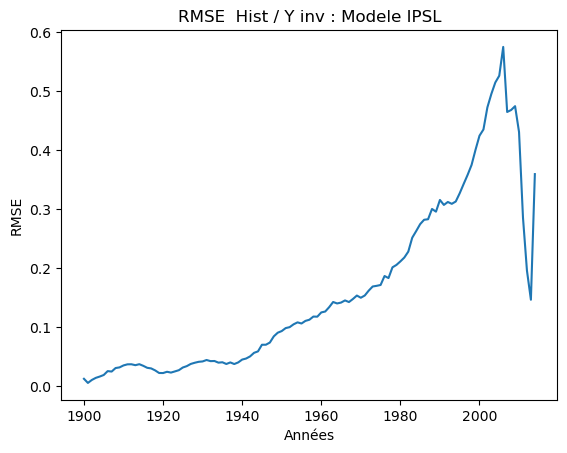

In [41]:
# Tracé du graphique
plt.plot(df_concat["years"], df_concat["rmse"])
plt.xlabel("Années")
plt.ylabel("RMSE")
plt.title("RMSE  Hist / Y inv : Modele IPSL")
plt.show()

In [42]:
import pandas as pd
import pickle
import ast

path = "/usr/home/habbar/Bureau/data_nc/data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_1mod_EssaiTRwAll2_NHLpFilt/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e300_bs100_Lr0.001-VfT15-TwALL/Inversion-on_IPSL-CM6A-LR/Inv_N0/SetL0.2/Av-ALL_best-valn/rmse_X-Xinv_dc.p"
# Ouverture du fichier pickle en mode lecture binaire
with open(path, 'rb') as f:
    rmse_dict = pickle.load(f)
# Création d'un DataFrame à partir du dictionnaire chargé
df = pd.DataFrame.from_dict(rmse_dict, orient='index').T
A = df.explode("rmse").explode("rmse").explode("rmse").reset_index()["rmse"]
B = df.explode("years").reset_index()["years"]
# Concaténer les DataFrames en colonnes
df_concat = pd.concat([A, B], axis=1)
# df_concat=df_concat.dropna()
print(df_concat)

         rmse years
0    0.571666  1882
1    0.556275  1883
2    0.548924  1884
3    0.552475  1885
4    0.560395  1886
..        ...   ...
394  0.764926   NaN
395  0.795849   NaN
396  0.816413   NaN
397  0.778418   NaN
398   0.81347   NaN

[399 rows x 2 columns]


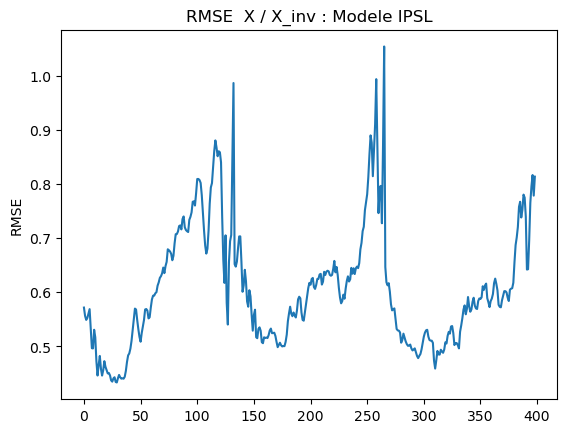

In [43]:
# Tracé du graphique
plt.plot( df_concat["rmse"])
# plt.xlabel("Années")
plt.ylabel("RMSE")
plt.title("RMSE  X / X_inv : Modele IPSL")
plt.show()

In [ ]:
#df = df[~(np.abs(df - df.mean()) > (3 * df.std()))]
'''np.isnan(df).any()

if np.isnan(df).any():
    # remplacer les NaN par la moyenne de la colonne
    df = np.nan_to_num(df, nan=np.nanmean(df, axis=0))'''


'''from collections import Counter

def detect_outliers(df, n, features):
    """
    Cette fonction détecte les valeurs aberrantes pour un dataframe donné, en utilisant la méthode de l'interquartile (IQR).
    Elle renvoie une liste des indices des valeurs aberrantes.
    df: dataframe
    n: nombre de valeurs aberrantes à détecter
    features: colonnes à utiliser pour la détection des valeurs aberrantes
    """
    outlier_indices = [] # Liste des indices des valeurs aberrantes
    # Parcourir les colonnes
    for col in features:
        Q1 = np.percentile(df[col], 25)                                                            # 1er quartile (25%)
        Q3 = np.percentile(df[col], 75)                                                            # 3ème quartile (75%)
        IQR = Q3 - Q1                                                                              # Intervalle interquartile (IQR)
        outlier_step = 1.5 * IQR                                                                   # Seuil pour détecter les valeurs aberrantes
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index # Liste des indices des valeurs aberrantes pour la colonne col
        outlier_indices.extend(outlier_list_col)                                                   # Ajouter les indices des valeurs aberrantes à la liste des indices des valeurs aberrantes
    outlier_indices = Counter(outlier_indices)                                                     # Compter le nombre de valeurs aberrantes pour chaque indice
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)                       # Sélectionner les indices des valeurs aberrantes qui apparaissent plus de n fois
    return multiple_outliers 

df = pd.DataFrame(df)                                                                              # Convertir le tableau numpy en dataframe
outliers_to_drop = detect_outliers(df, 2, df.columns)                                              # Détecter les valeurs aberrantes 
df = df.drop(outliers_to_drop, axis=0).reset_index(drop=True)                                      # Supprimer les valeurs aberrantes
df.describe()                                                                                      # Afficher les statistiques descriptives du dataframe
'''

'''# Remplacer les valeurs aberrantes par la moyenne de la colonne
df = np.nan_to_num(df, nan=np.nanmean(df, axis=0))
df_clean = pd.DataFrame(df)'''

'''import os
import pandas as pd

# Définir le répertoire contenant les fichiers CSV
directory = folder_path = f'C:/Users/cchoquet/Desktop/data_nc/stagelong/projetlong/data_source_dr/region{region}'

# Parcourir les fichiers CSV dans le répertoire
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Charger le fichier CSV dans un DataFrame pandas
        df = pd.read_csv(os.path.join(directory, filename))

        # Vérifier s'il y a des valeurs NaN
        if df.isna().any().any():
            print(f"Le fichier {filename} contient des valeurs NaN.")
        
        df = df.apply(pd.to_numeric, errors='coerce')
        # Calculer la médiane absolue de la déviation (MAD)
        #mad = np.median(np.abs(df - np.median(df)))

        # Définir un seuil personnalisé en fonction de la MAD
        #threshold = 3 * mad

        # Vérifier s'il y a des valeurs aberrantes
        #is_aberrant = (np.abs(df - np.median(df)) / mad > threshold)
        
        is_aberrant = df[df>]
        
        # Affichage du résultat
        if is_aberrant.any().any():
            print(f"Le fichier {filename} contient des valeurs aberrantes.")
            print(df[is_aberrant])
            
            # Supprimer les valeurs aberrantes
            df.drop(df[is_aberrant].index, inplace=True)
            print(f"Les valeurs aberrantes ont été supprimées :")
            df_clean = df
        else:
            print(f"Le fichier {filename} ne contient pas de valeurs aberrantes.")'''
            
'''
# Identifier les valeurs aberrantes avec l'écart interquartile (IQR)
df = pd.DataFrame(df)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
aberrant = ((df < (Q1 - 1.8 * IQR)) | (df > (Q3 + 1.8 * IQR))).any(axis=1)

# Supprimer les lignes contenant des valeurs aberrantes
df_clean = df[~aberrant]
# Afficher le nombre de lignes supprimées
print("Nombre de lignes supprimées : ", len(df) - len(df_clean))


# Visualiser le boxplot après la suppression des valeurs aberrantes
plt.figure(figsize=(10, 5))
plt.title("Boxplot après la suppression des valeurs aberrantes")
# afficher le boxplot en séparant chaque deux années
df_clean.boxplot()
plt.show()

df_clean_np = df_clean.to_numpy()









# Identifier les valeurs aberrantes avec l'écart interquartile (IQR)
#df = pd.DataFrame(df)
df0 = df.drop(columns=["modele","Variable"]).values
aberrant = (df0 > 100).any(axis=1)

# Supprimer les lignes contenant des valeurs aberrantes
df_clean = df0[~aberrant]
# Afficher le nombre de lignes supprimées
print("Nombre de lignes supprimées : ", len(df0) - len(df_clean))


# Visualiser le boxplot après la suppression des valeurs aberrantes
plt.figure(figsize=(10, 5))
plt.title("Boxplot après la suppression des valeurs aberrantes")
# afficher le boxplot en séparant chaque deux années
df_clean.boxplot()
plt.show()

df_clean_np = df_clean.to_numpy()
df.iloc[~aberrant].describe()
np.max(df.iloc[~aberrant].drop(columns=["modele","Variable"]).max())
aberrant
'''

'\n# Identifier les valeurs aberrantes avec l\'écart interquartile (IQR)\ndf = pd.DataFrame(df)\nQ1 = df.quantile(0.25)\nQ3 = df.quantile(0.75)\nIQR = Q3 - Q1\naberrant = ((df < (Q1 - 1.8 * IQR)) | (df > (Q3 + 1.8 * IQR))).any(axis=1)\n\n# Supprimer les lignes contenant des valeurs aberrantes\ndf_clean = df[~aberrant]\n# Afficher le nombre de lignes supprimées\nprint("Nombre de lignes supprimées : ", len(df) - len(df_clean))\n\n\n# Visualiser le boxplot après la suppression des valeurs aberrantes\nplt.figure(figsize=(10, 5))\nplt.title("Boxplot après la suppression des valeurs aberrantes")\n# afficher le boxplot en séparant chaque deux années\ndf_clean.boxplot()\nplt.show()\n\ndf_clean_np = df_clean.to_numpy()\n\n\n\n\n\n\n\n\n\n# Identifier les valeurs aberrantes avec l\'écart interquartile (IQR)\n#df = pd.DataFrame(df)\ndf0 = df.drop(columns=["modele","Variable"]).values\naberrant = (df0 > 100).any(axis=1)\n\n# Supprimer les lignes contenant des valeurs aberrantes\ndf_clean = df0[~ab